In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet
from CustomDataset import get_dataset
from CustomDataset import vec_trans

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp

In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 5*20*20

LOG_SOFTMAX_VALUES = False

dset = get_dataset('20news-bydate-test')

FILE = 'weights/Model_quicksave40.pt'

class_names = dset.classes
print(class_names)

rand_files = random.sample(range(len(dset)), NUM_MAPS)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
model = ConvNet(LOG_SOFTMAX_VALUES)

model.load_state_dict(torch.load(FILE))
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod, org, h, mode):
    '''
    Computes Loss Function
    '''
    
    
    ### Loss 1
    if mode == 1:
        z = torch.mean((mod[:,h]-org[:,h])**2)
    
    
    
    ### Loss 2
    if mode == 2:
        z = torch.mean((mod[:,:]-org[:,:])**2)
    
    ### Loss 3
    if mode == 3:
        z = mod-org
        z[:,h] = F.relu(org[:,h]-mod[:,h])
        z = torch.mean((F.relu(z))**2)
    
    ### Loss 4
    if mode == 4:
        z = mod-org
        z[:,h] = org[:,h]-mod[:,h]
        z = torch.mean(z)
    
    
    return z

In [5]:
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, norm=0, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc='left')
    tokens = words
    
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    if norm == 0:
        normalized_scores =  scores #/ np.max(np.abs(scores))
    elif norm == 1:
        normalized_scores =  0.5*scores/np.max(np.abs(scores)) + 0.5
    elif norm == 2:
        normalized_scores =  np.abs(scores)/np.max(np.abs(scores))
        
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')



In [6]:
with open('prepositions.txt','r') as f:
    prep = [p.strip() for p in f]
    
print(prep)

['aboard', 'about', 'above', 'across', 'after', 'against', 'along', 'amid', 'among', 'anti', 'around', 'as', 'at', 'before', 'behind', 'below', 'beneath', 'beside', 'besides', 'between', 'beyond', 'but', 'by', 'despite', 'down', 'during', 'except', 'for', 'from', 'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'outside', 'over', 'past', 'per', 'regarding', 'save', 'since', 'than', 'through', 'to', 'toward', 'under', 'underneath', 'unlike', 'until', 'up', 'upon', 'via', 'with', 'within', 'without', 'is', 'was', 'a', 'an', 'the']


In [7]:
def GenRelMap_GreedyOpt(x, indices, num=12):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    target = int(np.argmax(x_out.cpu().numpy(), axis=1))
    #print(target)
    
    order = [None]*num
    
    s = np.ones((64,1,x.shape[2],300))
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s.requires_grad = False
    
    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(64,1,x.shape[2],1))
    for i in range(64):
        n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
    n = torch.as_tensor(n.astype(np.float32)).to(device)
    
    for i in range(num):
        min_arg = -1
        min_acc = float('inf')
        
        for arg in indices:
            if arg in order[:i]:
                continue
            
            s[:,:,arg,:] = torch.zeros((64,1,300))
            data_input = (x_input-n)*s+n
            out = model(data_input)
            acc = torch.mean(out,dim=0)[target].cpu().numpy()#1.0*sum(temp)/64.0
            if acc<min_acc:
                min_arg = arg
                min_acc = acc
            s[:,:,arg,:] = torch.ones((64,1,300))
        
        order[i] = min_arg
        s[:,:,min_arg,:] = torch.zeros((64,1,300))
            
    return order

In [8]:
def GenRelMap_LF(x, mode, num_iters=400, lr =8e-3, gam = 0.95, lamb=750):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    
    if mode == 4:
        s = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s.requires_grad = True

        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[2],1))    
        for i in range(64):
            n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
        n = torch.as_tensor(n.astype(np.float32)).to(device)

        for i in range(num_iters):
            data_input = (x_input-n)*s+n
            out = model(data_input)

            loss = 0.5*comp_loss(out, x_out, highest_dim, mode=4)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                s = s.clamp_(0,1) #- s
            scheduler.step()

        return s.detach().cpu().numpy()
    if mode ==2:
        dirr = 0
        inc = 1.0
        while True:
            s = 0.1*np.random.rand(1,x.shape[2],1)
            s = torch.as_tensor(s.astype(np.float32)).to(device)
            s = torch.autograd.Variable(s, requires_grad=True)

            optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)
            for i in range(num_iters):

                n = vec_trans.matrixify('a',1)
                n = np.tile(n,(64,1,x.shape[2],1))
                for i in range(64):
                    n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
                n = torch.as_tensor(n.astype(np.float32)).to(device)

                data_input = (x_input-n)*s+n
                out = model(data_input)

                loss = 0.5*comp_loss(out,x_out,highest_dim,2)+lamb*torch.mean(torch.abs(s))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    s += s.clamp_(0,1) - s
                scheduler.step()
            #print(s.detach().cpu().numpy().mean())
            if s.detach().cpu().numpy().mean()>0.18:
                if dirr<0:
                    inc = inc/2
                    #print('A')
                lamb = lamb*(1+inc)
                dirr = 1
                #print('1')
            elif s.detach().cpu().numpy().mean()<0.07:
                if dirr > 0:
                    inc = inc/2
                    #print('B')
                lamb = lamb/(1+inc)
                dirr = -1
                #print('-1')
            else:
                break
        return s.detach().cpu().numpy()

In [9]:
N_PC = 7

rmap_opt_l2 = [None]*20
rmap_opt_l4 = [None]*20
rmap_opt_no = [None]*20
wds = [None]*20
pths = [None]*20

for x in range(20):
    rmap_opt_l2[x] = [0]*N_PC
    rmap_opt_l4[x] = [0]*N_PC
    rmap_opt_no[x] = [0]*N_PC
    wds[x] = [0]*N_PC
    pths[x] = [0]*N_PC
    
counter = [0]*20
_ = 0
c_ = 0
while not all(x == N_PC for x in counter):
    
    e = dset.get_words_list(rand_files[_])
    
    if len(e)<40 or len(e)>800:
        _ += 1
        continue
    
    sample, target, path = dset[rand_files[_]]
    sample = dset.get_custom_matrix(rand_files[_])
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if np.argmax(x_out) != target:    
        continue
        
    if counter[target] == N_PC:
        continue
    
    print(counter)
    c_ += 1
    ## Comb Opt
    ind = GenRelMap_GreedyOpt(sample, range(sample.shape[2]), num=12)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,13)[::-1]
    
    rmap_opt_no[target][counter[target]] = rel
    
    length = 25
    ## Opt Opt
    guider = GenRelMap_LF(sample, mode=2, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt(sample, z[:length], num=12)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,13)[::-1]
    rmap_opt_l2[target][counter[target]] = rel
    
    guider = GenRelMap_LF(sample, mode=4, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt(sample, z[:length], num=12)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,13)[::-1]
    rmap_opt_l4[target][counter[target]] = rel
    
    wds[target][counter[target]] = e
    pths[target][counter[target]] = path
    
    counter[target] += 1 
    
    if c_%10==0:
        print('##### At '+str(c_))
        np.save('rmap_data/rmap_greedy'+str(c_)+'.npy',[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1]
[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1]
##### At 10
[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 3, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
[0, 0, 3, 2,

[6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7]
##### At 140


In [10]:
np.save('relmap_greedy.npy',[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths])

In [9]:
[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths] = np.load('relmap_greedy.npy',allow_pickle=True)

20news-bydate-test/misc.forsale/76493


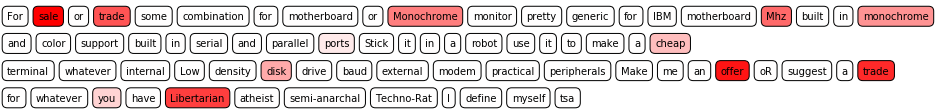

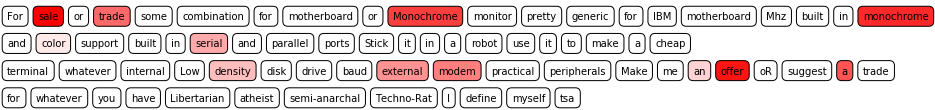

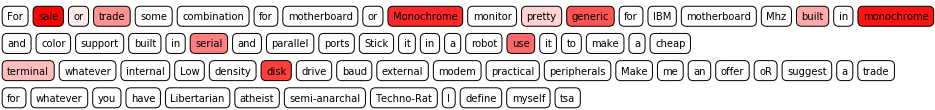

In [10]:
no = 4
cls = 6
print(pths[cls][no])
#print(rmap[cls][no])
plot_text_heatmap(wds[cls][no],rmap_opt_no[cls][no],norm=1)
plot_text_heatmap(wds[cls][no],rmap_opt_l2[cls][no],norm=1)
plot_text_heatmap(wds[cls][no],rmap_opt_l4[cls][no],norm=1)

In [11]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    # Reshaping to (BCHW)
    x = GlobalMaxPool2D('channels_last')(x)
    z = Dense(160,name='fc1',activation='relu')(x)
    z = Dropout(0.35)(z)
    out = Dense(20,name='fc2')(z)
    outz = Dropout(0.35)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20) 

In [12]:
## Verify Keras == PyTorch
x = dset[91][0]
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[ -2.9706852  -5.5049233  -6.077644   -5.367428   -8.464187   -7.1808844
   -6.4065485  -7.5148163  -3.8011968  -6.5148544  -6.619134   -4.959029
   -5.5789804  -2.1804993  -6.195535   -9.749821   -6.3438773 -10.35112
   -6.6495266  -1.1167698]]


tensor([[ -2.9707,  -5.5049,  -6.0776,  -5.3674,  -8.4642,  -7.1809,  -6.4065,
          -7.5148,  -3.8012,  -6.5149,  -6.6191,  -4.9590,  -5.5790,  -2.1805,
          -6.1955,  -9.7498,  -6.3439, -10.3511,  -6.6495,  -1.1168]],
       device='cuda:0')

In [13]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [14]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

analyzers = []

for method, kws in zip(methods, kwargs):
    #print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kws)
    #analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [19]:
from keras.layers import Softmax
import time

test_sample_paths = [pths[6][4]]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path(test_sample_paths[0])[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    

    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    #test_sample_preds[i] = y_hat
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)        ### Add the values along the embedding dimension
        analysis[i, aidx] = a

20news-bydate-test/misc.forsale/76493


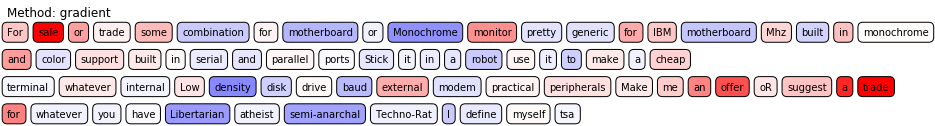

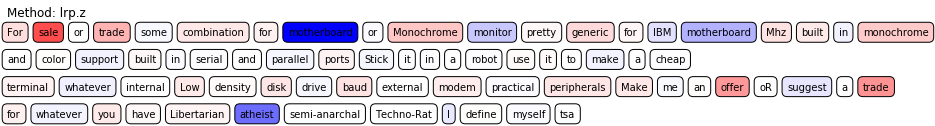

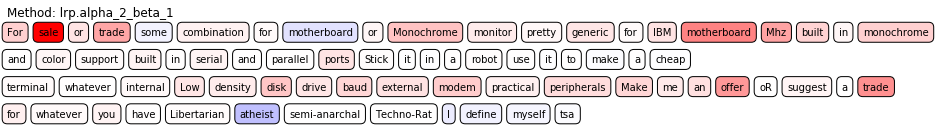

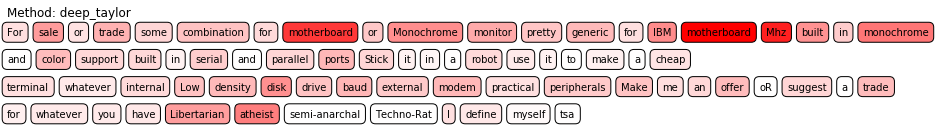

In [20]:
for i, idx in enumerate(test_sample_paths):

    words = dset.data_from_path(idx)[0]   
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=1, title='Method: %s' % method, verbose=0)
        plt.show()

In [21]:
test_sample_paths = []
for i in range(140):
    test_sample_paths.append(pths[i//7][i%7])

#test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [22]:
###### ACC GRAPH
def get_acc_zero(x,target,maps):
    BTCH = 1
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        #n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        n = np.zeros((BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval


###### ACC GRAPH
def get_acc_batched(x,target,maps):
    BTCH = 64
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(BTCH,1,x.shape[0],1))
        for it in range(BTCH):
            n[it] = np.tile(vec_trans.matrixify(prep[it],1),(1,1,x.shape[0],1))
        #n = torch.as_tensor(n.astype(np.float32)).to(device)
        
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [24]:
N_PC = 7

y1_acc=[[np.zeros(11)]*2]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
y3_acc=[[np.zeros(11)]*2]*140
y4_acc = [[np.zeros(11)]*len(analyzers)]*140

for i in range(7):
    for j in range(20):
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_opt_no[j][i]
        m2 = rmap_opt_l2[j][i]
        m3 = rmap_opt_l4[j][i]
        y1_acc[j*N_PC + i] = get_acc_zero(x,j,[m1,m2,m3])
        y2_acc[j*N_PC + i] = get_acc_zero(x,j,analyzis[j*7+i])
        y3_acc[j*N_PC + i] = get_acc_batched(x,j,[m1,m2,m3])
        y4_acc[j*N_PC + i] = get_acc_batched(x,j,analyzis[j*7+i])

In [25]:
z = np.array(y1_acc)
y1am = z.mean(axis=0)

z = np.array(y2_acc)
y2am = z.mean(axis=0)

z = np.array(y3_acc)
y3am = z.mean(axis=0)

z = np.array(y4_acc)
y4am = z.mean(axis=0)

Text(0, 0.5, 'Acc - Zero Replace')

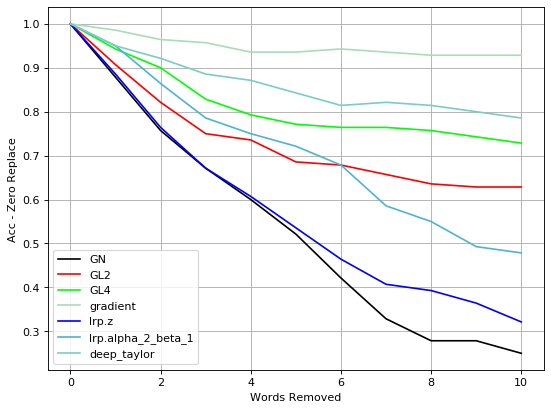

In [26]:
colors = ['#000000','#FF0000','#00FF00','#a8ddb5','#0000FF','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y1am[0],colors[0])
plt.plot(y1am[1],colors[1])
plt.plot(y1am[2],colors[2])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Zero Replace')

Text(0, 0.5, 'Acc - Batched Preposition')

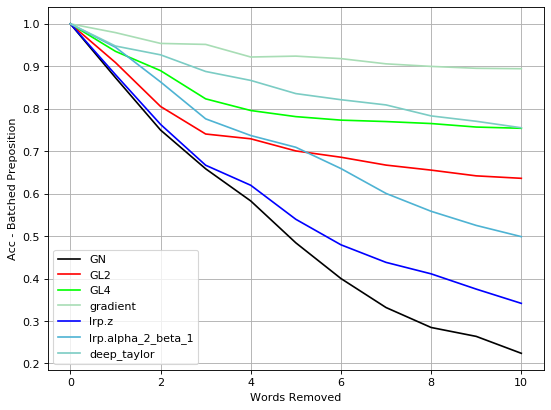

In [27]:
colors = ['#000000','#FF0000','#00FF00','#a8ddb5','#0000FF','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y3am[0],colors[0])
plt.plot(y3am[1],colors[1])
plt.plot(y3am[2],colors[2])

for i in range(y4am.shape[0]):
    plt.plot(y4am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched Preposition')

Text(0, 0.5, 'Distortion - L1')

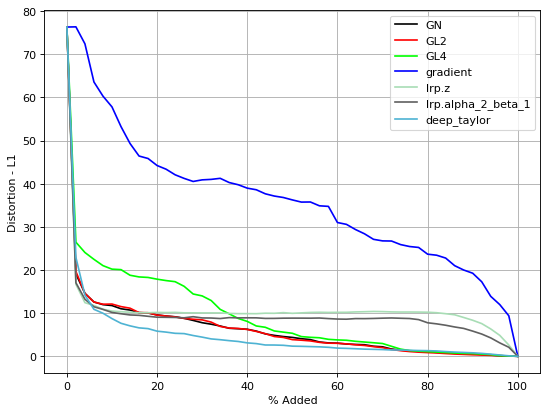

In [28]:
def get_distortion_curve(x,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        order = np.argsort(maps[i])[::-1]
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for j in range(64):
            n[j] = np.tile(vec_trans.matrixify(prep[j],1),(1,1,x.shape[0],1))
        
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            
            for c,k in enumerate(z):
                n[:,0,order[:k],:] = x[order[:k]]
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))
                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                yval[i][c] = comp_loss(out,x_out,highest_dim,mode=1).data.item()
                
    return yval


N_PC = 7
y=[[np.zeros(51)]*3]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_opt_no[j][i]
        m2 = rmap_opt_l2[j][i]
        m3 = rmap_opt_l4[j][i]
        y[j*N_PC + i] = get_distortion_curve(x,[m1,m2,m3])
        y2[j*N_PC + i] = get_distortion_curve(x,analyzis[j*7+i])
    
z = np.array(y)
ym = z.mean(axis=0)
z = np.array(y2)
y2m = z.mean(axis=0)

colors = ['#000000','#FF0000','#00FF00','#0000FF','#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym[0],colors[0])
plt.plot(x_ax,ym[1],colors[1])
plt.plot(x_ax,ym[2],colors[2])


for i in range(len(y2m)):
    plt.plot(x_ax,y2m[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion - L1')

# Code

In [10]:
pth_ind = {}
for i in range(7):
    for j in range(20):
        ind = 0
        x = pths[j][i]
        for k in rand_files:
            if dset[k][2] == x:
                ind = k
                break
                
        pth_ind[x] = ind

In [11]:
rmin = float('+inf')
rmax = float('-inf')

for i in range(7):
    for j in range(20):
        k = pth_ind[pths[j][i]]
        
        x = torch.as_tensor(dset.get_custom_matrix(k))
        #print(x.shape)
        inf = torch.min(x)
        sup = torch.max(x)
        if inf< rmin:
            rmin = inf
            #print('A')
        if sup> rmax:
            #print('B')
            rmax = sup
        
print(rmin.data.item())
print(rmax.data.item())

-1.6328125
1.296875


20news-bydate-test/soc.religion.christian/21556


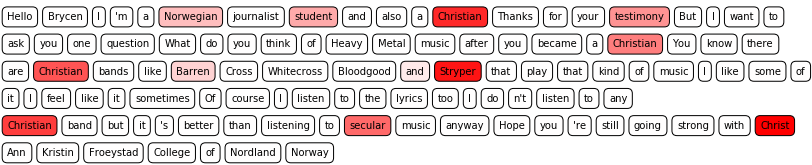

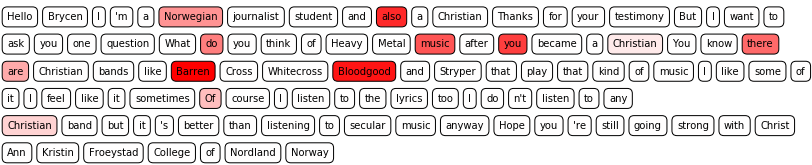

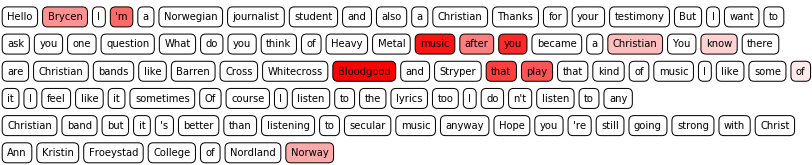

In [12]:
no = 2
cls = 15
#print(pths)
#rand_files.index(pths[cls][no])-1
#print(pths[cls][no])
print(pths[cls][no])
x = wds[cls][no]

    
plot_text_heatmap(x,rmap_opt_no[cls][no],norm=1)
plot_text_heatmap(x,rmap_opt_l2[cls][no],norm=1)
plot_text_heatmap(x,rmap_opt_l4[cls][no],norm=1)

In [13]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    # Reshaping to (BCHW)
    x = GlobalMaxPool2D('channels_last')(x)
    z = Dense(160,name='fc1',activation='relu')(x)
    z = Dropout(0.35)(z)
    out = Dense(20,name='fc2')(z)
    outz = Dropout(0.35)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

Using TensorFlow backend.
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4

channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20) 

In [14]:
x = dset[71][0]
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[ -0.32578993  -5.588904    -8.394347   -12.566721    -8.588877
   -8.034335   -11.947057    -8.0307045   -8.665789    -6.3758326
  -11.250446   -10.845068   -12.00159     -9.034694    -2.967912
    0.2598915  -13.77081     -9.623329    -8.066677    -4.164794  ]]


tensor([[ -0.3258,  -5.5889,  -8.3943, -12.5667,  -8.5889,  -8.0343, -11.9471,
          -8.0307,  -8.6658,  -6.3758, -11.2504, -10.8451, -12.0016,  -9.0347,
          -2.9679,   0.2599, -13.7708,  -9.6233,  -8.0667,  -4.1648]],
       device='cuda:0')

In [15]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [16]:
train_set = get_dataset('20news-bydate-train')

train_data = np.zeros((len(train_set),1,400,300))
for i in range(len(train_set)):
    train_data[i] = train_set[i][0]

train_data = train_data.reshape((-1,400,300,1))
print(train_data.shape)

(11314, 400, 300, 1)


In [18]:
input_range = (-1.6328125,1.296875)

analyzers = []


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


methods = [
    # NAME                    OPT.PARAMS         
    ("gradient",              {},           "Gradient"),
    #("smoothgrad",            {"noise_scale": noise_scale,"postprocess": "square"},     "SmoothGrad"),
    ("deconvnet",             {},           "Deconvnet"),
    ("guided_backprop",       {},           "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, "PatternNet"),
    ("pattern.attribution",   {"pattern_type": "relu"}, "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, "DeepTaylor"),
    ("input_t_gradient",      {},          "Input * Gradient"),
    #("integrated_gradients",  {"reference_inputs": ri},   "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri},    "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"}, "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},   "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},    "LRP-Epsilon"),
]





for method in methods:
    #print(method)
    analyzer = innvestigate.create_analyzer(method[0], k_model,**method[1]) #neuron_selection_mode="index", 
    analyzer.fit(train_data, batch_size=128, verbose=1)
    analyzers.append(analyzer)

Epoch 1/1
89/89 [==============================] - 22s 243ms/step - loss: 3.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000 - broadcast_9_loss: 1.0000
Epoch 1/1
89/89 [==============================] - 22s 247ms/step - loss: 3.0000 - broadcast_10_loss: 1.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000


In [19]:
from keras.layers import Softmax
import time

test_sample_paths = [pths[2][4]]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path(test_sample_paths[0])[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    

    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    #test_sample_preds[i] = y_hat
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)        ### Add the values along the embedding dimension
        analysis[i, aidx] = a

20news-bydate-test/comp.os.ms-windows.misc/10683


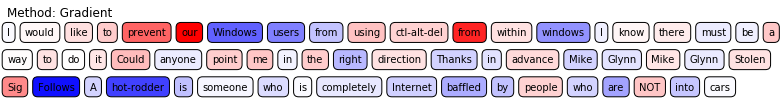

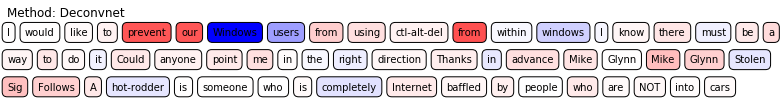

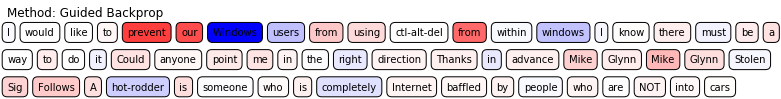

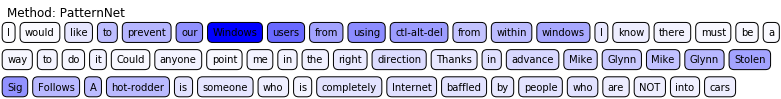

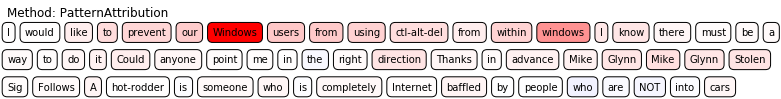

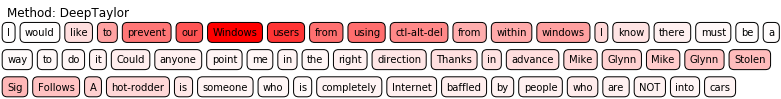

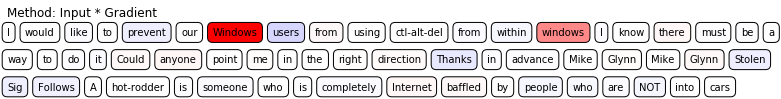

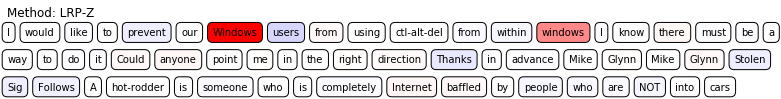

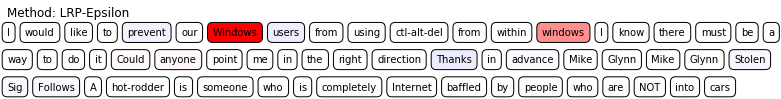

In [20]:
names = [method[2] for method in methods]
for i, idx in enumerate(test_sample_paths):

    words = dset.data_from_path(idx)[0]   
    for j, method in enumerate(methods):
        
        #if names[j] == 'PatternNet':
        #        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=2, title='Method: %s' % method[2], verbose=0)
        #else:
            plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=1, title='Method: %s' % method[2], verbose=0)
            plt.show()

In [21]:
test_sample_paths = []
for i in range(140):
    test_sample_paths.append(pths[i//7][i%7])

#test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [22]:
###### ACC GRAPH
def get_acc_zero(x,target,maps):
    BTCH = 1
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        #n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        n = np.zeros((BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval


###### ACC GRAPH
def get_acc_batched(x,target,maps):
    BTCH = 64
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for it in range(64):
            n[it] = np.tile(vec_trans.matrixify(prep[it],1),(1,1,x.shape[0],1))
        #n = torch.as_tensor(n.astype(np.float32)).to(device)
        
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [25]:
N_PC = 7
y1_acc=[[np.zeros(11)]*2]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
y3_acc=[[np.zeros(11)]*2]*140
y4_acc = [[np.zeros(11)]*len(analyzers)]*140

for i in range(7):
    for j in range(20):
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_opt_no[j][i]
        m2 = rmap_opt_l2[j][i]
        m3 = rmap_opt_l4[j][i]
        y1_acc[j*N_PC + i] = get_acc_zero(x,j,[m1,m2,m3])
        y2_acc[j*N_PC + i] = get_acc_zero(x,j,analyzis[j*7+i])
        y3_acc[j*N_PC + i] = get_acc_batched(x,j,[m1,m2,m3])
        y4_acc[j*N_PC + i] = get_acc_batched(x,j,analyzis[j*7+i])
        
    print(i)

0
1
2
3
4
5
6


In [26]:
z = np.array(y1_acc)
y1am = z.mean(axis=0)

z = np.array(y2_acc)
y2am = z.mean(axis=0)

z = np.array(y3_acc)
y3am = z.mean(axis=0)

z = np.array(y4_acc)
y4am = z.mean(axis=0)

In [24]:

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:1
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


Text(0, 0.5, 'Acc - Zero Replace')

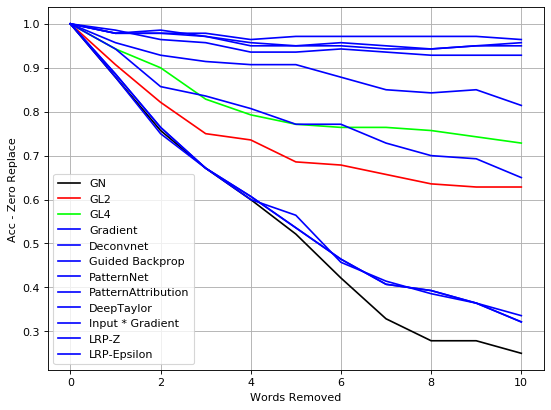

In [27]:
colors = ['#000000','#FF0000','#00FF00']+len(names)*['#0000FF']#,'#a8ddb5','#0000FF','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y1am[0],colors[0])
plt.plot(y1am[1],colors[1])
plt.plot(y1am[2],colors[2])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4']+names)
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Zero Replace')

In [31]:
colors = ['#000000','#FF0000','#00FF00']+len(names-2)*['#0000FF']+['#a8ddb5','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y3am[0],colors[0])
plt.plot(y3am[1],colors[1])
plt.plot(y3am[2],colors[2])

for i in range(y4am.shape[0]):
    plt.plot(y4am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4']+names)
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched')

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [30]:
print(y4am)

[[1.         0.97935268 0.95390625 0.9515625  0.921875   0.92399554
  0.91808036 0.90580357 0.89977679 0.8953125  0.89430804]
 [1.         0.98504464 0.98515625 0.97209821 0.95535714 0.94787946
  0.94330357 0.92991071 0.93102679 0.92421875 0.91082589]
 [1.         0.98638393 0.98359375 0.96595982 0.95212054 0.94520089
  0.93705357 0.93069196 0.93571429 0.93348214 0.92991071]
 [1.         0.98002232 0.98113839 0.97890625 0.97533482 0.97075893
  0.96283482 0.959375   0.95959821 0.95680804 0.95591518]
 [1.         0.9375     0.86272321 0.82879464 0.78303571 0.76004464
  0.76205357 0.72834821 0.69877232 0.67957589 0.64352679]
 [1.         0.95546875 0.93348214 0.92087054 0.915625   0.90502232
  0.890625   0.85703125 0.84341518 0.84296875 0.81841518]
 [1.         0.88035714 0.76316964 0.66696429 0.61975446 0.53962054
  0.47957589 0.43816964 0.41116071 0.37522321 0.34162946]
 [1.         0.88035714 0.76316964 0.66696429 0.61975446 0.53962054
  0.47957589 0.43816964 0.41116071 0.37522321 0.34